# Main Notebook to Train Classifier

## Load libraries

In [1]:
from os import listdir
from os.path import join
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
import torch.nn as nn

from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from torchvision.transforms import v2
from tqdm.notebook import tqdm

## Define Dataset and DataLoader

In [2]:
class SegmentedImageDataset(Dataset):
    def __init__(self, image_dir: str, segmented_dir: str, metadata_path: str, image_transforms: Optional[v2.Compose], mask_transforms: Optional[v2.Compose], unified_transforms: Optional[v2.Compose]):
        metadata_df = pl.read_csv(metadata_path).with_columns(file_key=pl.col('FileName_OrigRNA').str.split('-').list.first().str.reverse().str.slice(3).str.reverse())

        self.metadata_dict = metadata_df.select('file_key', 'Metadata_pert_iname').to_pandas().set_index('file_key')['Metadata_pert_iname'].to_dict()
        self.target_dict = {tgt: torch.tensor(i, dtype=torch.int64) for i, tgt in enumerate(metadata_df.get_column('Metadata_pert_iname').unique())}
        
        self.image_dir = image_dir
        self.images = listdir(image_dir)
        self.segmented_dir = segmented_dir
        
        assert len(self.images) == len(listdir(segmented_dir))
        self.length = len(self.images)
        
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.unified_transforms = unified_transforms
        
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        img_file_name = self.images[index]
        img = Image.open(join(self.image_dir, img_file_name))
        img = img if self.image_transforms is None else self.image_transforms(img)
        
        seg = torch.tensor(np.load(join(self.segmented_dir, img_file_name + '.npy')).astype('int64')).unsqueeze(0)
        seg = seg if self.mask_transforms is None else self.mask_transforms(seg)
        
        out = torch.cat((seg, img))
        out = out if self.unified_transforms is None else self.unified_transforms(out)
        
        target = self.target_dict[self.metadata_dict[img_file_name.split('_')[0]]]
        
        return out, target
        
    def __len__(self) -> int:
        return self.length
    
    def n_classes(self) -> int:
        return len(self.target_dict)

In [3]:
BATCH_SIZE = 128

rng = torch.random.manual_seed(77)
dataset = SegmentedImageDataset(
    'Data/downsampled_data', 
    'Segmented', 
    'Data/metadata_BR00116991.csv', 
    v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    None,
    v2.Compose([
        v2.RandomResizedCrop(128)
    ])
)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=rng)
train_loader, test_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True), DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Make sure everything is working properly

In [13]:
next(iter(train_loader))[0].size()

torch.Size([128, 2, 128, 128])

Example Mask


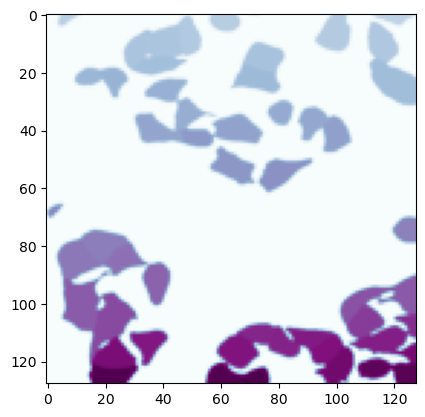

Example Image


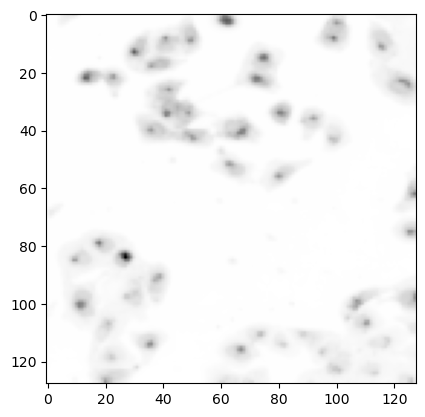

Example Masked Image


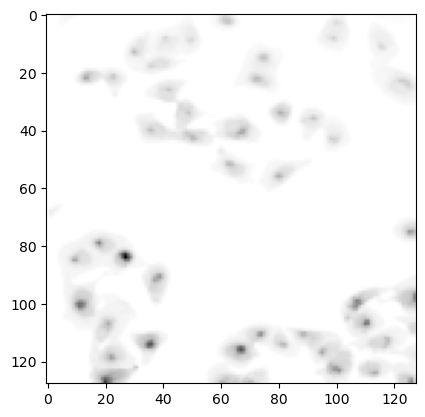

In [4]:
samp = next(iter(train_loader))[0][0]

_ = plt.imshow(samp[0], cmap='BuPu')
print('Example Mask')
plt.show()

_ = plt.imshow(samp[1], cmap='Grays')
print('Example Image')
plt.show()

plt.imshow(samp[0] * samp[1], cmap='Grays')
print('Example Masked Image')
plt.show()

## Define the Training and Test Procedures

In [14]:
def train_loop(device, classifier, train_loader, optimizer, scheduler, loss_fn, n_epochs):
    losses, accs = [], []
    classifier.train()
    for epoch in range(1, 1+n_epochs):
        loss_val = 0
        acc_val = 0
        n = 0
        for (X, y) in tqdm(train_loader):
            m = y.size(0)
    
            X, y = torch.prod(X, dim=1, keepdim=True).to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
        
        print(f'Epoch {epoch}: Loss = {loss_val / n:.3f}; Accuracy = {acc_val / n:.3f}')
        losses.append(loss_val / n)
        accs.append(acc_val / n)
        
        scheduler.step()
    
    return np.array(losses), np.array(accs)


In [15]:
def test_loop(device, classifier, test_loader, loss_fn) -> Tuple[float, float]:
    classifier.eval()
    loss_val = 0
    acc_val = 0
    n = 0
    for (X, y) in tqdm(test_loader):
        m = y.size(0)

        X, y = torch.prod(X, dim=1, keepdim=True).to(device), y.to(device)
        yhat = classifier(X)
        pred = torch.argmax(yhat, dim=1)
        
        loss = loss_fn(yhat, y)
        acc = (pred == y).sum()
                   
        loss_val += loss.item() * m
        acc_val += acc.item()
        n += m
    
    return loss_val / n, acc_val / n


## Fit the model

In [16]:
device = torch.device('mps')

clf = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding='same'), 
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 32, kernel_size=3, padding='same'),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.BatchNorm1d(16384),
    nn.Linear(16384, 128),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, dataset.n_classes())
).to(device)

optim = torch.optim.Adam(clf.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

for _ in range(3):
    losses, accs = train_loop(device, clf, train_loader, optim, scheduler, loss_fn, 5)
    test_loss, test_acc = test_loop(device, clf, test_loader, loss_fn)
    print(f'Test Loss: {test_loss:.3f}; Test Accuracy: {test_acc:.3f}')

torch.save(losses, 'losses.pt')
torch.save(accs, 'accuracies.pt')
torch.save(clf.state_dict(), 'clf.pth')
test_loss, test_acc = test_loop(device, clf, test_loader, loss_fn)

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 21.498; Accuracy = 0.032


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 7.606; Accuracy = 0.004


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 6.190; Accuracy = 0.004


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 5.498; Accuracy = 0.071


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 5.186; Accuracy = 0.177


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 5.078; Test Accuracy: 0.180


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 5.093; Accuracy = 0.174


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 5.072; Accuracy = 0.176


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 5.038; Accuracy = 0.176


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 5.027; Accuracy = 0.175


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 5.039; Accuracy = 0.177


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.966; Test Accuracy: 0.180


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 5.010; Accuracy = 0.177


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.974; Accuracy = 0.175


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.969; Accuracy = 0.176


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.957; Accuracy = 0.175


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 4.963; Accuracy = 0.176


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.950; Test Accuracy: 0.175


  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
torch.save(clf, 'clf_main.pth')